In [1]:
import numpy as np
import matplotlib.pyplot as plt

## The Verlet integrator
$$
r(t+\delta t) = 2r(t)-r(t-\delta t)+\frac{f(t)}{m}\delta t^2+\mathcal{O}(\delta t^4)
$$
$$
v(t)=\frac{r(t+\delta t)-r(t-\delta t)}{2\delta t}+\mathcal{O}(\delta t^2)
$$

In [4]:
class HarmParticle:
    def __init__(self, x0:float, v0:float, integrator):
        # Initial conditions
        self.x0 = x0
        self.v0 = v0
        self.a0 = NotImplemented
        self.iter = -1 # So that the storage index is intuitive
        
        # integrator
        self.integrator = integrator
        
        # Properties
        self.x = NotImplemented
        self.v = NotImplemented
        self.a = NotImplemented
        self.ke = NotImplemented
        self.pe = NotImplemented
        self.etot = NotImplemented
        
        # Scratch variable for Verlet
        self.x_old = NotImplemented
        
        # Data storage
        self.x_traj = NotImplemented
        self.v_traj = NotImplemented
        
        self.initialise()
        
    def initialise(self):
        if self.iter != -1:
            raise RuntimeError("Particle.initialise() called after instantiation")
        else:
            self.x = self.x0
            self.v = self.v0
            self.energyEval()
            self.forceEval()
            self.a0 = self.a # So that the complete set of initial conditions is available
            self.x_traj = [self.x]
            self.v_traj = [self.v]
            self.iter += 1
    
    def energyEval(self):
        self.ke = 0.5 * self.v**2
        self.pe = 0.5 - self.x**2 + 0.5*self.x**4
        self.etot = self.ke + self.pe
        
    def forceEval(self):
        # currently trivial and unncessary, but in case we need to change
        self.a = 2*self.x - 2*self.x**3
    
    def takeStep(self, maxIter):
        while self.iter < maxIter:
            self.integrator(self)
            self.x_traj.append(self.x)
            self.v_traj.append(self.v)
            self.iter += 1
    
    def reset(self):
        self.iter = -1
        self.initialise()

class Integrator:
    def __init__(self, dt):
        self.dt = dt
    
    def eulerStep(self, pt):
        pt.x = pt.x + pt.v * self.dt
        pt.v = pt.v + pt.a * self.dt
        pt.forceEval()
        
    def verletStep(self, pt):
        if pt.iter == 0:
            # first Verlet iteration has to be Euler
            pt.x_old = pt.x + pt.v * self.dt
            pt.forceEval()
        
        x_new = 2*pt.x - pt.x_old + pt.a*(self.dt**2)
        pt.v = (x_new - pt.x_old)/(2*self.dt)
        pt.x_old = pt.x
        pt.x = x_new
        pt.forceEval()

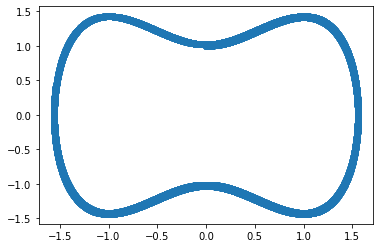

In [11]:
myEuler = Integrator(0.001).eulerStep
p1 = HarmParticle(0.0, 1.0, myEuler)
p1.takeStep(10000)
plt.scatter(p1.x_traj,p1.v_traj)
p1.reset()